# Lab 12: A/B Testing and Estimation

Welcome to Lab 12 ! In this lab, we'll be taking a look at topics covered in chapters 11, 12, and 13.

Outline:

     1: A/B Testing
    
     2: Murder Rates
     
     3: The Death Penalty
     
     4: Thai Restaurants
     
     5: Interpreting Confidence Intervals
     
Run the cells below to get started.     

In [72]:
from datascience import *
import pandas as pd
import numpy as np 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. A/B Testing

A/B testing is a form of hypothesis testing that allows you to make comparisons between two distributions.

You'll almost never be explicitly asked to perform an A/B test. Make sure you can identify situations where the test is appropriate and know how to correctly implement each step.

**Question 1:** The following statements are the unordered steps of an A/B hypothesis test:

Choose a test statistic (typically the difference in means between two categories)

Shuffle the labels of the original sample, find your simulated test statistic, and repeat many times

   1. Find the value of the observed test statistic

   2. Calculate the p-value based off your observed and simulated test statistics

   3. Define a null and alternate model

   4. Use the p-value and p-value cutoff to draw a conclusion about the null hypothesis

Make an array called ab_test_order that contains the correct order of an A/B test, where the first item of the array is the first step of an A/B test and the last item of the array is the last step of an A/B test

In [74]:
ab_test_order = [3, 1, 2, 4]
ab_test_order

[3, 1, 2, 4]

**Question 2:** If the null hypothesis of an A/B test is correct, should the order of labels affect the differences in means between each group? Why do we shuffle labels in an A/B test?

If the null hypothesis of an A/B test is correct then all the rearrangements of the labels are equally
likely. The labels are shuffled in order to truly test the null hypothesis.

## 2: Murder Rates

Punishment for crime has many [philosophical justifications](http://plato.stanford.edu/entries/punishment/#ThePun).  An important one is that fear of punishment may *deter* people from committing crimes.

In the United States, some jurisdictions execute people who are convicted of particularly serious crimes, such as murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project we'll focus on deterrence.

The key question about deterrence is:

> Through our exploration, does instituting a death penalty for murder actually reduce the number of murders?

You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  We'll try to come to our own conclusion.

#### The data

The main data source for this lab comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled the data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

In [75]:
murder_rates = pd.read_csv('crime_rates.csv')
murder_rates = murder_rates.filter(items = ['State', 'Year', 'Population', 'Murder Rate'])
murder_rates

,State,Year,Population,Murder Rate
0,Alaska,1960,226167,10.2
1,Alaska,1961,234000,11.5
2,Alaska,1962,246000,4.5
3,Alaska,1963,248000,6.5
4,Alaska,1964,250000,10.4
...,...,...,...,...
2195,Wyoming,1999,480000,2.3
2196,Wyoming,2000,493782,2.4
2197,Wyoming,2001,494423,1.8
2198,Wyoming,2002,498830,3.0


Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. Let's plot a couple, just to see the variety.

**Question 1:** Create a table called `ak_mn` that will hold the years and murder rates for alaska and minnesota such that the result looks like this:

| Year | Murder rate in Alaska | Murder rate in Minnesota |
|------|-----------------------|--------------------------|
| 1960 | 10.2                  | 1.2                      |
| 1961 | 11.5                  | 1                        |
| 1962 | 4.5                   | 0.9                      |

<center>... (41 rows omitted)</center>

In [76]:
m_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
m_rates.set_format("Population", NumberFormatter)
ak = m_rates.where('State', "Alaska").drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format("Alaska"))
mn = m_rates.where('State', "Minnesota").drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format("Minnesota"))
ak_mn = ak.join('Year', mn)

**Question 2:** Using the table `ak_mn`, draw a line plot that compares the murder rate in Alaska and the murder rate in Minnesota over time.

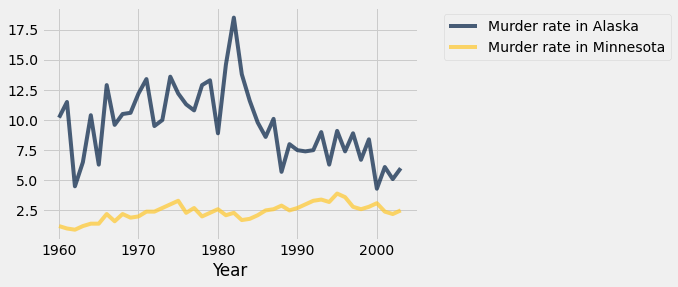

In [77]:

ak_mn.plot('Year')
plt.show()

Now what about the murder rates of other states? Say, for example, California and New York? Run the cell below to plot the murder rates of different pairs of states.

In [78]:
# Compare the murder rates of any two states by filling in the blanks below

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

m_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
m_rates.set_format("Population", NumberFormatter)

def state(state1, state2):
    state1_table = m_rates.where('State', state1).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state1))
    state2_table = m_rates.where('State', state2).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state2))
    s1_s2 = state1_table.join('Year', state2_table)
    s1_s2.plot('Year')
    plt.show()

states_array = m_rates.group('State').column('State')

_ = interact(state,
             state1=widgets.Dropdown(options=list(states_array),value='California'),
             state2=widgets.Dropdown(options=list(states_array),value='New York')
           )

interactive(children=(Dropdown(description='state1', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkans…

## 3. The Death Penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the presence of the death penalty affects the murder rate of a state.

**Question 1:** We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?


There could be other factors affecting the murder rate, not only the death penalty enforcement.

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, we're going to take advantage of a *natural experiment*.  A **natural experiment** happens when something other than experimental design applies a treatment to one group and not to another (control) group, and we have some hope that the treatment and control groups don't have any other systematic differences.

Our natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.

As a first step, let's see how murder rates changed before and after the court decision.  We'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in 1973 (the year after 1972).

> **Control group:** The states in that population, in 1971 (the year before 1972).

> **Null hypothesis:** Murder rates in 1971 and 1973 come from the same distribution.

> **Alternative hypothesis:** Murder rates were higher in 1973 than they were in 1971.

Our alternative hypothesis is related to our suspicion that murder rates increase when the death penalty is eliminated.  

**Question 2:** Should we use an A/B test to test these hypotheses? If yes, what is our "A" group and what is our "B" group?

A Group is the Treatment Group and B Group is the Control Group.

The `death_penalty` table below describes whether each state allowed the death penalty in 1971.

In [79]:
non_death_penalty_states = pd.array(['Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota'])

def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    return state not in non_death_penalty_states


states = murder_rates.groupby('State').count()
death_penalties = []
for state in states.index:
    death_penalties.append(had_death_penalty_in_1971(state))

states['Death Penalty'] = death_penalties    
states = states.drop(columns = ['Year','Population', 'Murder Rate'])

states

,Death Penalty
State,
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True


**Question 3:** Use the `death_penalty` and `murder_rates` tables to find murder rates in 1971 for states with the death penalty before the abolition. Create a new table `preban_rates` that contains the same information as `murder_rates`, along with a column `Death Penalty` that contains booleans (`True` or `False`) describing if states had the death penalty in 1971.

In [80]:
death_penalty = states
death_penalty = death_penalty.reset_index()
t_death_penalty = death_penalty[death_penalty['Death Penalty']==True]
t_death_penalty

,State,Death Penalty
0,Alabama,True
2,Arizona,True
3,Arkansas,True
4,California,True
5,Colorado,True
6,Connecticut,True
7,Delaware,True
8,Florida,True
9,Georgia,True
11,Idaho,True


In [87]:
murder_rates_1971 = murder_rates[murder_rates["Year"] == 1971]
preban_rates = murder_rates_1971.join(t_death_penalty.set_index("State"), on="State")
preban_rates = preban_rates.set_index("State")
preban_rates = preban_rates.reset_index()
preban_index = preban_rates[preban_rates["Death Penalty"] != True].index 
preban_rates = preban_rates.drop(preban_index)
preban_rates

,State,Year,Population,Murder Rate,Death Penalty
1,Alabama,1971,3479000,15.1,True
2,Arkansas,1971,1944000,10.5,True
3,Arizona,1971,1849000,6.7,True
4,California,1971,20223000,8.1,True
5,Colorado,1971,2283000,6.5,True
6,Connecticut,1971,3081000,3.1,True
7,Delaware,1971,558000,6.1,True
8,Florida,1971,7041000,13.3,True
9,Georgia,1971,4664000,16.0,True
11,Iowa,1971,2852000,1.8,True


**Question 4:** Create a table `postban_rates` that contains the same information as preban_rates, but for 1973 instead of 1971. postban_rates should only contain the states found in preban_rates.

In [97]:
murder_rates_1973 = murder_rates[murder_rates["Year"] == 1973]
postban_rates = murder_rates_1973.join(t_death_penalty.set_index("State"), on="State")
postban_rates = postban_rates.set_index("State")
postban_rates = postban_rates.reset_index()
postban_index = postban_rates[postban_rates["Death Penalty"] != True].index 
postban_rates = postban_rates.drop(postban_index)
postban_rates["Death Penalty"] = False
postban_rates

,State,Year,Population,Murder Rate,Death Penalty
1,Alabama,1973,3539000,13.2,False
2,Arkansas,1973,2037000,8.8,False
3,Arizona,1973,2058000,8.1,False
4,California,1973,20601000,9.0,False
5,Colorado,1973,2437000,7.9,False
6,Connecticut,1973,3076000,3.3,False
7,Delaware,1973,576000,5.9,False
8,Florida,1973,7678000,15.4,False
9,Georgia,1973,4786000,17.4,False
11,Iowa,1973,2904000,2.2,False


**Question 5** Use `preban_rates_copy` and `postban_rates` to create a table `change_in_death_rates` that contains each state's population, murder rate, and whether or not that state had the death penalty for both 1971 and 1973. 

*Hint:* `tbl_1.append(tbl_2)` with create a new table that includes rows from both `tbl_1` and `tbl_2`. Both tables must have the exactly the same columns, in the same order.

In [98]:
preban_rates_copy = preban_rates
change_in_death_rates = preban_rates_copy.append(postban_rates)
change_in_death_rates

,State,Year,Population,Murder Rate,Death Penalty
1,Alabama,1971,3479000,15.1,True
2,Arkansas,1971,1944000,10.5,True
3,Arizona,1971,1849000,6.7,True
4,California,1971,20223000,8.1,True
5,Colorado,1971,2283000,6.5,True
...,...,...,...,...,...
44,Virginia,1973,4811000,10.5,False
45,Vermont,1973,464000,2.2,False
46,Washington,1973,3429000,4.0,False
48,West Virginia,1973,1794000,5.7,False


**Question 6:** Create a table `rate_means` that contains the average murder rates for the states that had the death penalty and the states that didn't have the death penalty. It should have two columns: one indicating if the penalty was in place, and one that contains the average murder rate for each group.

In [118]:
#rate_means = change_in_death_rates.group("Death Penalty", np.average).drop("Population average","Year average","State average")
rate_means = change_in_death_rates.groupby("Death Penalty").mean()
rate_means = rate_means.drop("Population", axis=1)
rate_means = rate_means.drop("Year", axis=1)
rate_means = rate_means.rename(columns={"Murder Rate": "Murder Rate Average"})
rate_means

,Murder Rate Average
Death Penalty,
False,8.120455
True,7.513636


**Question 7:** We want to figure out if there is a difference between the distribution of death rates in 1971 and 1973. Specifically, we want to test if murder rates were higher in 1973 than they were in 1971. 

What should the test statistic be? How does it help us differentiate whether the data supports the null and alternative? 

To test if murder rates were higher in 1973 than in 1971 then the test statistic should be 0.6068. The data also supports that in 1973 the murder rate was higher thus supports the Alternative Hypothesis.


**Question 8:** Set `observed_difference` to the observed test statistic using the `rate_means` table 

In [126]:
observed_difference = rate_means["Murder Rate Average"][0] - rate_means["Murder Rate Average"][1]
observed_difference

0.6068181600659113

**Question 9:** Given a table like `change_in_death_rates`, a value column `label`, and a group column `group_label`, write a function that calculates the appropriate test statistic.

In [138]:
def find_test_stat(table, labels_col, values_col):
  selection = table.groupby(labels_col).mean()
  diff = selection[values_col][0] - selection[values_col][1]
  return diff

find_test_stat(change_in_death_rates, "Death Penalty", "Murder Rate")

0.6068181600659113

When we run a simulation for A/B testing, we resample by shuffling the labels of the original sample. If the null hypothesis is true and the murder rate distributions are the same, we expect that the difference in mean death rates will be not change when "Death Penalty" labels are changed.

**Question 10:** Write a function `simulate_and_test_statistic` to compute one trial of our A/B test. Your function should run a simulation and return a test statistic.

Note: The test here is fairly lenient, if you have an issue with the following questions, make sure to take a look at your answer to **Question 9** . Specifically, make sure that you are taking the directionality of our alternative hypothesis into account.

In [140]:
def simulate_and_test_statistic(table, labels_col, values_col):
    shuffled_column = table.sample(with_replacement = False).column(values_col)
    new_table = table.drop(values_col).with_column("Shuffled Label", shuffled_column)
    return find_test_stat(new_table, labels_col, "Shuffled Label")

simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")

TypeError: ignored

**Question 11:** Simulate 5000 trials of our A/B test and store the test statistics in an array called `differences`

In [ ]:
# This cell might take a couple seconds to run
differences = ...
                                                 
differences

Run the cell below to view a histogram of your simulated test statistics plotted with your observed test statistic

**Question 12:** Create  a histogram of your simulated test statistics plotted with your observed test statistic

**Question 13:** Find the p-value for your test and assign it to `empirical_P`

In [ ]:
empirical_P = ...
empirical_P

**Question 13:** Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses. Describe your findings using simple, non-technical language. What does your analysis tell you about murder rates after the death penalty was suspended? What can you claim about causation from your statistical analysis?

*Write your answer here, replacing this text.*

## 4. Thai Restaurants


Ben and Frank are trying see what the best Thai restaurant in Berkeley is. They survey 1500 UC Berkeley students selected uniformly at random, and ask each student what Thai restaurant is the best (*Note: this data is fabricated for the purposes of this homework*). The choices of Thai restaurant are Lucky House, Imm Thai, Thai Temple, and Thai Basil. After compiling the results, Ben and Frank release the following percentages from their sample:

|Thai Restaurant  | Percentage|
|:------------:|:------------:|
|Lucky House | 8% |
|Imm Thai | 52% |
|Thai Temple | 25% |
|Thai Basil | 15% |

These percentages represent a uniform random sample of the population of UC Berkeley students. We will attempt to estimate the corresponding *parameters*, or the percentage of the votes that each restaurant will receive from the entire population (the entire population is all UC Berkeley students). We will use confidence intervals to compute a range of values that reflects the uncertainty of our estimates.

The table `votes` contains the results of the survey.

In [ ]:
# Just run this cell
votes = pd.read_csv('votes.csv')
#votes

**Question 1:** Complete the function `one_resampled_percentage` below. It should return Imm Thai's **percentage** of votes after simulating one bootstrap sample of `tbl`.

**Note:** `tbl` will always be in the same format as `votes`.

In [ ]:
def one_resampled_percentage(tbl):
    ...

one_resampled_percentage(votes)

**Question 2:** Complete the `percentages_in_resamples` function such that it returns an array of 2500 bootstrapped estimates of the percentage of voters who will vote for Imm Thai. You should use the `one_resampled_percentage` function you wrote above.

*Note:* There are no public tests for this question, the autograder cell below will return 0.0% passed. 

def percentages_in_resamples():
    percentage_imm = make_array()
    ...

**Question 3:** Create a histogram of the calculated statistic for the 2,500 bootstrap estimates of the percentage of voters who voted for Imm Thai.

**Note:** Use the function created in **Question 2**.

Based on what the original Thai restaurant percentages were, does the graph seem reasonable? 

**Question 3:** Using the array `resampled_percentages`, find the values at the two edges of the middle 95% of the bootstrapped percentage estimates. (Compute the lower and upper ends of the interval, named `imm_lower_bound` and `imm_upper_bound`, respectively.)

**Question 4:** The survey results seem to indicate that Imm Thai is beating all the other Thai restaurants combined among voters. We would like to use confidence intervals to determine a range of likely values for Imm Thai's true lead over all the other restaurants combined. The calculation for Imm Thai's lead over Lucky House, Thai Temple, and Thai Basil combined is:

$$\text{Imm Thai's % of the vote} - \text{(Lucky House's % of the vote + Thai Temple's % of the vote + Thai Basil's % of the vote)}$$

Define the function `one_resampled_difference` that returns **exactly one value** of Imm Thai's percentage lead over Lucky House, Thai Temple, and Thai Basil combined from one bootstrap sample of `tbl`.

In [ ]:
def one_resampled_difference(tbl):
    bootstrap = ...
    imm_percentage = ...
    lh_percentage = ...
    tt_percentage = ...
    tb_percentage = ...
    ...

**Question 5:**
Write a function called `leads_in_resamples` that finds 2,500 bootstrapped estimates (the result of calling `one_resampled_difference`) of Imm Thai's lead over Lucky House, Thai Temple, and Thai Basil combined. **Plot a histogram** of the resulting samples. 

**Note:** Imm Thai's lead can be negative.

In [ ]:
def leads_in_resamples():
    ...

sampled_leads = leads_in_resamples()

**Question 6:** Use the simulated data from Question 5 to compute an approximate 95% confidence interval for Imm Thai's true lead over Lucky House, Thai Temple, and Thai Basil combined.


In [ ]:
diff_lower_bound = ...
diff_upper_bound = ...
print("Bootstrapped 95% confidence interval for Imm Thai's true lead over Lucky House, Thai Temple, and Thai Basil combined: [{:f}, {:f}]".format(diff_lower_bound, diff_upper_bound))

## 2. Interpreting Confidence Intervals
The staff computed the following 95% confidence interval for the percentage of Imm Thai voters: 

$$[49.40, 54.47]$$

(Your answer may have been a bit different; that doesn't mean it was wrong!)

**Question 1:** Can we say there is a 95% probability that the interval [49.40, 54.47] contains the true percentage of the population that votes for Imm Thai as the best Berkeley Thai restaurant? Answer "yes" or "no" and explain your reasoning. 

*Write your answer here, replacing this text.*

**Question 2:** The staff also created 70%, 90%, and 99% confidence intervals from the same sample, but we forgot to label which confidence interval represented which percentages! Match each confidence level (70%, 90%, 99%) with its corresponding interval in the cell below (e.g. __ % CI: [49.87, 54.0] $\rightarrow$ replace the blank with one of the three confidence levels). **Then**, explain your thought process and how you came up with your answers.

The intervals are below:

* [49.87, 54.00]
* [50.67, 53.27]
* [48.80, 55.40]

*Write your answer here, replacing this text.*

**Question 3:**
Suppose we produced 5,000 new samples (each one a uniform random sample of 1,500 voters/students) from the population and created a 95% confidence interval from each one. Roughly how many of those 5,000 intervals do you expect will actually contain the true percentage of the population?

Assign your answer to `true_percentage_intervals`.

In [ ]:
true_percentage_intervals = ...

Recall the second bootstrap confidence interval you created, which estimated Imm Thai's lead over Lucky House, Thai Temple, and Thai Basil combined. Among
voters in the sample, Imm Thai's lead was 4%. The staff's 95% confidence interval for the true lead (in the population of all voters) was

$$[-0.80, 8.80]$$

Suppose we are interested in testing a simple yes-or-no question:

> "Is the percentage of votes for Imm Thai tied with the percentage of votes for Lucky House, Thai Temple, and Thai Basil combined?"

Our null hypothesis is that the percentages are equal, or equivalently, that Imm Thai's lead is exactly 0. Our alternative hypothesis is that Imm Thai's lead is not equal to 0.  In the questions below, don't compute any confidence interval yourself - use only the staff's 95% confidence interval.

**Question 4:** Say we use a 5% P-value cutoff.  Do we reject the null, fail to reject the null, or are we unable to tell using our staff confidence interval?

Assign `restaurants_tied` to the number corresponding to the correct answer.

1. Reject the null / Data is consistent with the alternative hypothesis
2. Fail to reject the null / Data is consistent with the null hypothesis
3. Unable to tell using our staff confidence interval

*Hint:* If you're confused, take a look at [this chapter](https://www.inferentialthinking.com/chapters/13/4/using-confidence-intervals.html) of the textbook.

In [ ]:
restaurants_tied = ...

**Question 5:**
What if, instead, we use a P-value cutoff of 1%? Do we reject the null, fail to reject the null, or are we unable to tell using our staff confidence interval?

Assign `cutoff_one_percent` to the number corresponding to the correct answer.

1. Reject the null / Data is consistent with the alternative hypothesis
2. Fail to reject the null / Data is consistent with the null hypothesis
3. Unable to tell using our staff confidence interval

In [ ]:
cutoff_one_percent = ...

**Question 6:**
What if we use a P-value cutoff of 10%? Do we reject, fail to reject, or are we unable to tell using our confidence interval?

Assign `cutoff_ten_percent` to the number corresponding to the correct answer.

1. Reject the null / Data is consistent with the alternative hypothesis
2. Fail to reject the null / Data is consistent with the null hypothesis
3. Unable to tell using our staff confidence interval

In [ ]:
cutoff_ten_percent = ...